# By Shengyen Li, shengyen.li@swri.org

In [1]:
import os
import sys

import matplotlib.pyplot as plt

%matplotlib inline


import numpy as np
import pandas as pd

import dask
from dask import delayed

In [ ]:
# only if you have TC Python interface
#
from tc_python import *

# Calculations using TC-Python

In [2]:
#
# TC Module
#
class CALPHADModule:
    
    def __init__(self, databases, elements):

        self.databases = databases

        #
        # use absolute path
        #
        self.DBPath = [os.path.join(os.path.abspath(''), 'CALPHAD_DBs', x) for x in self.databases]
        

        #
        # first of the array is the major element
        #
        self.elements = elements

        #self.TCDBs = os.listdir("C:\\Program Files\\Thermo-Calc\\2019a\\data")
        self.TCDBs = os.path.join("C","Users","sli","Thermo-Calc","2019a","data")
        
        
    #
    # the phases variable only works when rejectPhases == "*" 
    #
    def TCEq(self,printOut,conditions,rejectPhases,phases):

        if(printOut):
            print("============================================")
            print(conditions)


        No_conds_ = len(list(conditions.keys()))

        if(No_conds_ != len(self.elements)): print("degree of freedom is not satisfied")
        
            
            
        with TCPython() as session:
        #with TCPython(logging_policy=LoggingPolicy.NONE) as session:

            #
            # Create equilibrium calculation object and set condtions
            #
            cachePath = "TC_cache\\"+str(os.getpid())
            eq_calculation = session.set_cache_folder(cachePath)
            
            
            #
            # 04/24/2019
            # full equilibrium calculations don't need the mobility database
            #
            idb_ = 0
                
            if(self.databases[idb_] in self.TCDBs):
                eq_calculation = eq_calculation.select_database_and_elements(self.databases[idb_], self.elements)

                if(rejectPhases):

                    if(rejectPhases[0] == "*"):
                        eq_calculation = eq_calculation.deselect_phase("*")
                        for phase_ in phases:
                            eq_calculation = eq_calculation.select_phase(phase_)


                    else:
                        for phase_ in rejectPhases:
                            eq_calculation = eq_calculation.deselect_phase(phase_)



            else:
                eq_calculation = eq_calculation.select_user_database_and_elements(self.DBPath[idb_], self.elements)

                if(rejectPhases):

                    if(rejectPhases[0] == "*"):
                        eq_calculation = eq_calculation.deselect_phase("*")
                        for phase_ in phases:
                            eq_calculation = eq_calculation.select_phase(phase_)


                    else:
                        for phase_ in rejectPhases:
                            eq_calculation = eq_calculation.deselect_phase(phase_)

                    

            try:
                eq_calculation = eq_calculation.get_system()
            except:
                sys.exit("Incorrect database information. ")
                
                
                
            if(printOut): print("Phases in calculation: ",eq_calculation.get_phases_in_system())
            
            
            system_phases = np.array(eq_calculation.get_phases_in_system())
            if(printOut): print("%d phases included in this system:  " % len(system_phases))


            eq_calculation = eq_calculation.with_single_equilibrium_calculation()
            eq_calculation.set_condition("P", 100000.0).set_condition("N", 1.0)

            #
            # Calculate equilibrium and list stable phases
            #
            for cond_ in list(conditions.keys()):
                eq_calculation.set_condition(cond_,conditions[cond_])

            calc_result = eq_calculation.calculate()

            
            #
            # stable phase and information
            #
            stable_phases = calc_result.get_stable_phases()

            
            #
            # phase composition under equilibrium consition
            #
            conds_ = list(conditions.keys())
            conds_.remove("T")

            
            phaseProp = {}
            
            properties = {}
            for elem_ in self.elements:
                temp_ = "ACR(" + elem_ + ")"
                properties[elem_] = calc_result.get_value_of(temp_)

            phaseProp["ACR"] = properties

            
            
            for stable_phase in stable_phases:
                properties = {}
                
                for cond_ in conds_:
                    temp_ = cond_[:2] + stable_phase + "," + cond_[2:]
                    properties[cond_] = round(calc_result.get_value_of(temp_),8)
                    
                    
                PhaseFraction = round(calc_result.get_value_of('NP('+stable_phase+')'),8)
                if(printOut): print("stable_phase:  ", stable_phase, "fraction:  ", PhaseFraction)

                properties["PhaseFraction"] = PhaseFraction
                
                
                GM = round(calc_result.get_value_of('GM('+stable_phase+')'),8)
                if(printOut): print("Gibbs free energy:  ", GM)

                properties["GM"] = GM
                

                #
                # if the molar volume is included in database
                # if not, VM=0
                #
                try:
                    VM = calc_result.get_value_of('VM('+stable_phase+')')
                    if(printOut): print("Molar Volume:  ", VM)

                    properties["VM"] = VM
                    
                except:
                    properties["VM"] = 0.
                
                
                phaseProp[stable_phase] = properties
                
                                
                    
            #
            # calculate solidus temperature and list stable phases
            # 
            #
            if(not rejectPhases):
                
                try:
                    phaseProp["VM"] = calc_result.get_value_of('VM')
                except:
                    phaseProp["VM"] = 0.
                
                
                calc_result = (eq_calculation.
                               remove_condition(ThermodynamicQuantity.temperature()).
                               set_phase_to_fixed("LIQUID", 0.0).
                               calculate())

                phaseProp["solidus"] = calc_result.get_value_of(ThermodynamicQuantity.temperature())


                calc_result = (eq_calculation.
                               set_phase_to_fixed("LIQUID", 1.0).
                               calculate())

                phaseProp["liquidus"] = calc_result.get_value_of(ThermodynamicQuantity.temperature())

                    
        return(phaseProp)

# Define a function for DASK
## the equilibrium conditions are: X(Al)=0.075 and X(Cr)=0.085

In [3]:
def daskFunction(T_):
    
    CALPHAD_Calculation = CALPHADModule(CALPHAD_DBs, elements)
    
    if((isinstance(T_, float)) or (isinstance(T_, int))):
        cond = {"X(Al)":0.075,"X(Cr)":0.085,"T":T_}
        eqProperty = CALPHAD_Calculation.TCEq(printOut,cond,[],[])  #["ACR"]["Ni"]
        
  
    else:
        eqProperty = []
        for T__ in T_:
            cond = {"X(Al)":0.075,"X(Cr)":0.085,"T":T__}
            eqProperty.extend([CALPHAD_Calculation.TCEq(printOut,cond,[],[])])
    

    return(eqProperty)

# Use MatClac database to calculate Ni-Al-Cr alloy

In [4]:
CALPHAD_DBs = ["mc_ni_v2.033_SLi_PC.tdb"]
elements = ["Ni","Al","Cr"]

targetPhase = "GAMMA_PRIME#1"


printOut = False

# Sequential calculations calling TC-Python

In [5]:
%%time

printOut=False

temperature = np.linspace(273,973,endpoint=True,num=21)
seqProp = daskFunction(temperature)

Wall time: 1min 16s


# DASK manages the same calculations

In [6]:
%%time


temperature = np.linspace(273,973,endpoint=True,num=21)

#prop = daskFunction(temperature)
prop = [delayed(daskFunction)(temp_) for temp_ in temperature]


#'threading', 'processes', 'sync'
#prop = dask.compute(prop,scheduler='sync')[0]
prop = dask.compute(prop,scheduler='processes')[0]


#client.close()


Wall time: 12 s


# setup for PyCALPHAD

In [7]:
from pycalphad import equilibrium, Database
import pycalphad.variables as v

In [8]:
%%time


CALPHAD_DBs = ["mc_ni_v2.033_SLi_PC.tdb"]
elements = ["NI","AL","CR","VA"]


TDB = Database(os.path.join(os.path.abspath(''), 'CALPHAD_DBs', CALPHAD_DBs[0]))
AllPhases = TDB.phases.keys()


eq = equilibrium(TDB, elements, AllPhases, {v.X('AL'): 0.075, v.X('CR'): 0.085, v.T: (273, 974, 35), v.P: 101325})

phase_indices = eq.Phase.values == targetPhase[:-2]

#
# If the target phase is not stable, temperature data will not match phase data
#
PyT = []
PyProp = []
for ind_ in range(phase_indices.shape[2]):
    if(any(phase_indices[0,0,ind_,0,0])):
        
        PyT.extend([eq['T'].values[ind_]])
        PyProp.extend([eq.NP.values[phase_indices][ind_]])

Wall time: 42.9 s


# Calculation time:
## TC-Python: 76s
## DASK + TC-Python: 12s
## PyCALPHAD: 42.9s

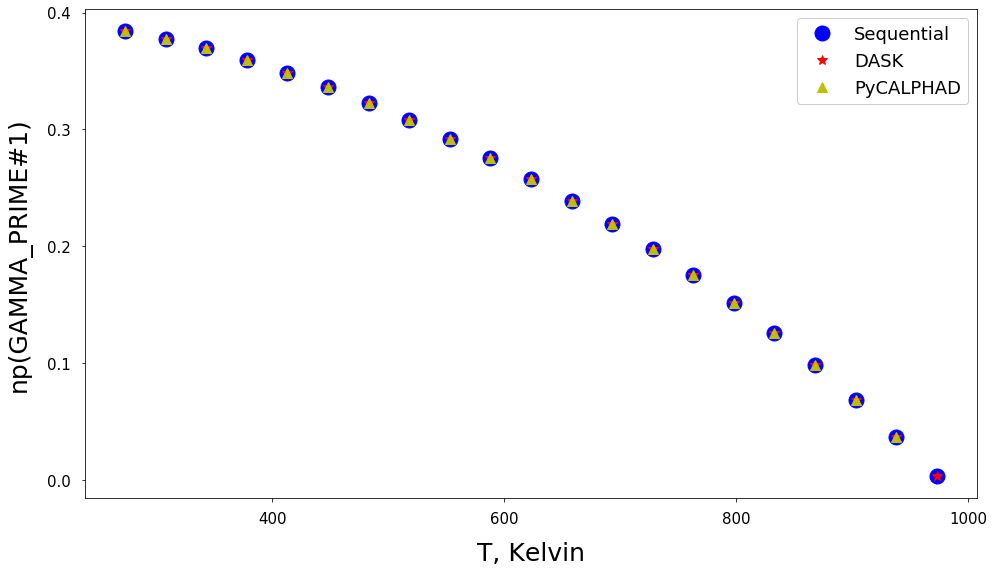

In [9]:
fig, ax = plt.subplots(figsize=(16,9))

for ind_ in range(len(seqProp)):
    try:
        phase = [seqProp[ind_][targetPhase]['PhaseFraction']]
        ax.plot(temperature[ind_],phase,'o',c='b',ms=15,label="Sequential")
        
    except:
        pass
    
for ind_ in range(len(prop)):
    try:
        phase = [prop[ind_][targetPhase]['PhaseFraction']]
        ax.plot(temperature[ind_],phase,'*',c='r',ms=10,label="DASK")
        
    except:
        pass

    
ax.plot(PyT,PyProp,'^',c='y',ms=10,label="PyCALPHAD")


ax.set_xlabel("T, Kelvin", fontsize=25, labelpad=15)
ax.set_ylabel("np("+targetPhase+")", fontsize=25, labelpad=15)

ax.tick_params(axis='x', labelsize=15, pad = 10)
ax.tick_params(axis='y', labelsize=15, pad = 10)


ax.locator_params(axis='x',nbins=5)
ax.locator_params(axis='y',nbins=5)


# ======================================================================
handles, labels = ax.get_legend_handles_labels()
uniqueLabels = list(set(labels))

index_ = [labels.index(lab) for lab in uniqueLabels]
index_.sort()


hand = [handles[ind_] for ind_ in index_]
lab = [labels[ind_] for ind_ in index_]


leg = plt.legend(hand, lab, loc='best', fontsize=18, scatterpoints=1, framealpha=1)
# ======================================================================

plt.show()

# PyCALPHAD misses the highest temperature.